1. 마지막 일자를 기준으로 인구 대비 확진자 비율이 높은 상위 5개 국가를 구하여라. 

- 상위 5개 국가별로 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자, 그래프, 범례를 이용해 가독성 있게 만들어라.

In [2]:
import pandas as pd
df = pd.read_csv('problem2.csv')
df.head()

,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations
0,Afghanistan,2020-02-24,5.0,NaN,NaN,39835428.0,NaN
1,Afghanistan,2020-02-25,5.0,NaN,NaN,39835428.0,NaN
2,Afghanistan,2020-02-26,5.0,NaN,NaN,39835428.0,NaN
3,Afghanistan,2020-02-27,5.0,NaN,NaN,39835428.0,NaN
4,Afghanistan,2020-02-28,5.0,NaN,NaN,39835428.0,NaN


In [3]:
df.isna().sum()

location                 0
date                     0
total_cases           7588
total_deaths         18857
new_tests            79870
population             980
new_vaccinations    107517
dtype: int64

In [4]:
df = df.fillna(0)
df.isna().sum()

location            0
date                0
total_cases         0
total_deaths        0
new_tests           0
population          0
new_vaccinations    0
dtype: int64

In [5]:
df['ratio'] = df['total_cases']/df['population']
df.head()

,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations,ratio
0,Afghanistan,2020-02-24,5.0,0.0,0.0,39835428.0,0.0,1.255164e-07
1,Afghanistan,2020-02-25,5.0,0.0,0.0,39835428.0,0.0,1.255164e-07
2,Afghanistan,2020-02-26,5.0,0.0,0.0,39835428.0,0.0,1.255164e-07
3,Afghanistan,2020-02-27,5.0,0.0,0.0,39835428.0,0.0,1.255164e-07
4,Afghanistan,2020-02-28,5.0,0.0,0.0,39835428.0,0.0,1.255164e-07


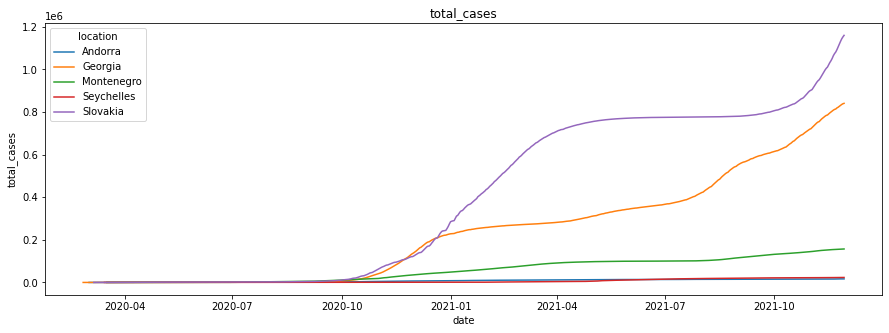

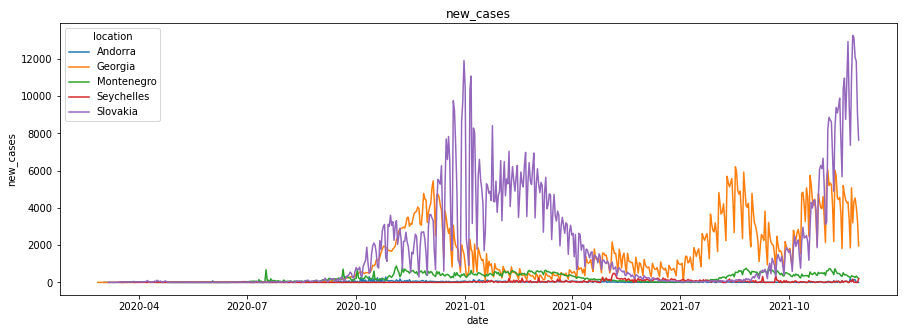

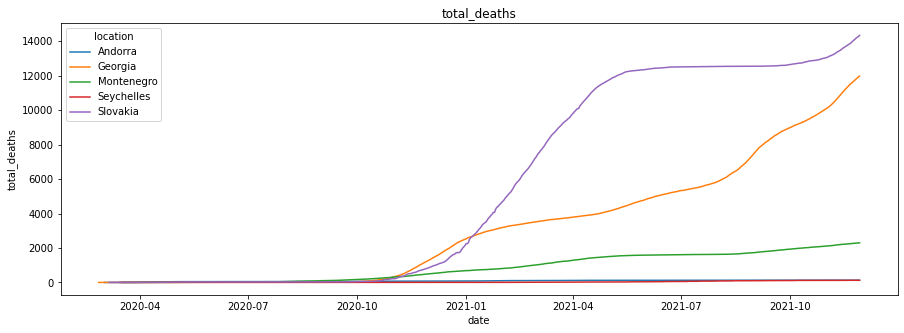

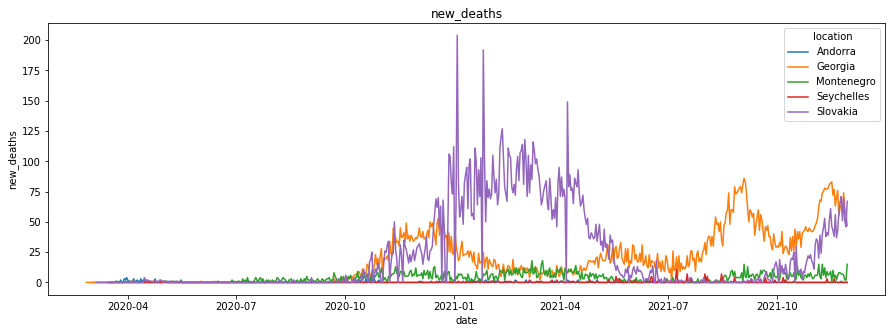

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


df['date'] = pd.to_datetime(df['date'])
df = df[df.date != pd.to_datetime('2021-11-30')]
df = df[df.population != 0]

for location in df.location.unique():
    lo = df[df.location == location]
    df.loc[lo.index,'new_cases'] = lo.total_cases.diff().values
    df.loc[lo.index[0], 'new_cases'] = lo['total_cases'].values[0]
    
    df.loc[lo.index,'new_deaths'] = lo.total_deaths.diff().values
    df.loc[lo.index[0],'new_deaths'] = lo['total_deaths'].values[0]
    
    df.loc[lo.index, 'total_vacciantions'] = lo['new_vaccinations'].cumsum().values
    df.loc[lo.index,'7days_new_case'] = lo['new_tests'].rolling(7).sum().fillna(0).values
    
locations = df.groupby(['location']).tail(1).sort_values('ratio',ascending=False).location.head(5).values
target = df[df.location.isin(locations)].reset_index(drop=True)

for v in ['total_cases','new_cases','total_deaths','new_deaths']:
    plt.figure(figsize=(15,5))
    plt.title(v)
    sns.lineplot(data=target,x='date',y=v,hue='location')
    plt.show()

2. 코로나 위험지수를 직접 만들고 그 위험지수에 대한 설명을 적고 위험 지수가 높은 국가들 10개를 선정해서 시각화

코로나 위험지수는 코로나로 인한 국가의 위기 정도를 표현한다. 코로나 전파 특성상 최근 일주일의 확진자 숫자가 그 다음의 일주일에 영향을 준다. 일일 사망자수는 현재 코로나의 국가 내에서의 치명율을 표현한다. 위기정도는 누적 백신인구에 의해 감소될 수 있다. 국가간의 비교를 위해 각 국가의 인구수로 나눠 값을 스케일링하고, 변수간 보정상수를 통해 정수화를 유도한다.

위험지수 = (최근 일주일 누적 확진자 / 인구수) + (일일 사망자/일일 인구수) - (누적 백신 인구/ 인구수) * 보정 상수

In [9]:
def ratio_index(x):
    value = (x['7days_new_case']/x['population'] 
             + x['new_deaths']/x['population']
             - x['total_vacciantions']/x['population'] * 0.001) * 100
    return value

df['ratio_index'] = df.apply(ratio_index,axis=1)

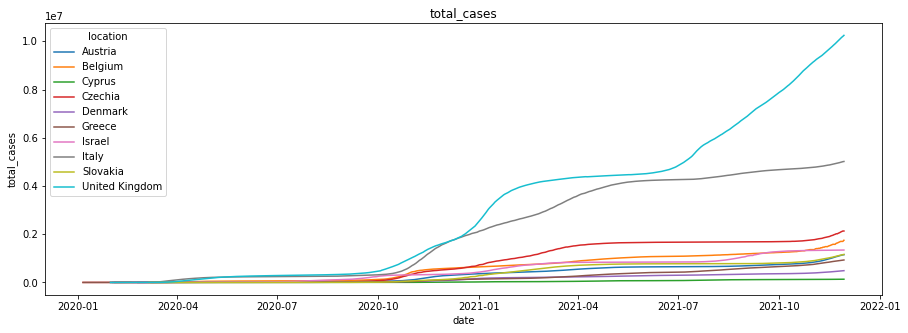

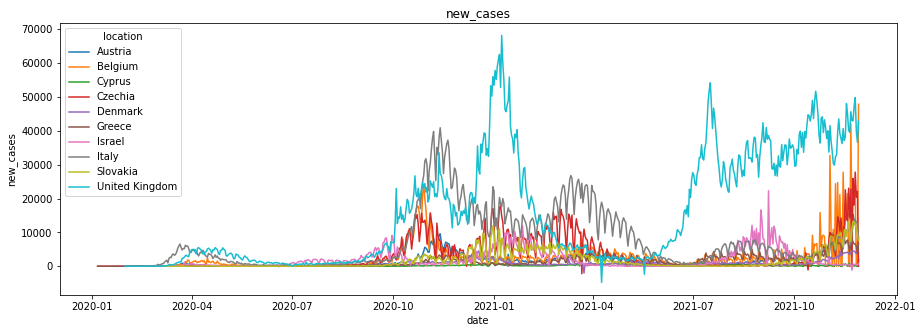

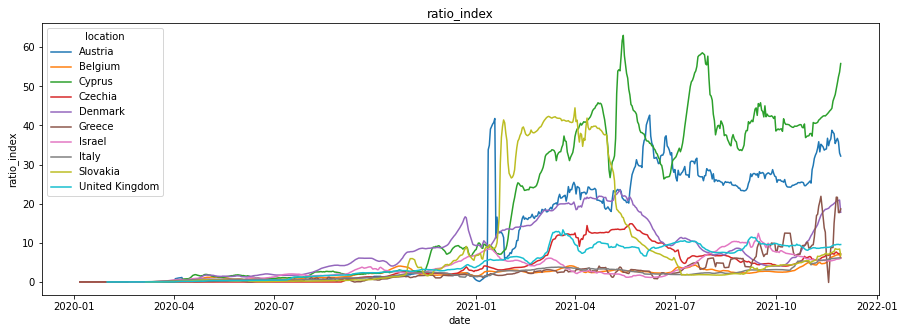

In [11]:
locations = df.groupby(['location']).tail(1).sort_values('ratio_index',ascending=False).location.head(10).values
target = df[df.location.isin(locations)].reset_index(drop=True)

for v in ['total_cases','new_cases','ratio_index']:
    plt.figure(figsize=(15,5))
    plt.title(v)
    sns.lineplot(data=target,x='date',y=v,hue='location')
    plt.show()

3. 한국의 코로나 신규 확진자 예측해라.
(선형 시계열 모델 + 비선형시계열 각각 한개씩 만들어라)

In [12]:
ko = df[df.location == 'South Korea'].reset_index(drop=True)
ko.head()

,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations,ratio,new_cases,new_deaths,total_vacciantions,7days_new_case,ratio_index
0,South Korea,2020-01-21,0.0,0.0,0.0,51305184.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,South Korea,2020-01-22,1.0,0.0,5.0,51305184.0,0.0,1.949121e-08,1.0,0.0,0.0,0.0,0.0
2,South Korea,2020-01-23,1.0,0.0,0.0,51305184.0,0.0,1.949121e-08,0.0,0.0,0.0,0.0,0.0
3,South Korea,2020-01-24,2.0,0.0,0.0,51305184.0,0.0,3.898242e-08,1.0,0.0,0.0,0.0,0.0
4,South Korea,2020-01-25,2.0,0.0,0.0,51305184.0,0.0,3.898242e-08,0.0,0.0,0.0,0.0,0.0


                            AutoReg Model Results                             
Dep. Variable:              new_cases   No. Observations:                  679
Model:                     AutoReg(3)   Log Likelihood               -4376.552
Method:               Conditional MLE   S.D. of innovations            156.844
Date:                Sat, 11 Jun 2022   AIC                           8763.103
Time:                        23:54:26   BIC                           8785.684
Sample:                             3   HQIC                          8771.846
                                  679                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.0652      7.966      1.264      0.206      -5.547      25.678
new_cases.L1     0.9978      0.037     27.163      0.000       0.926       1.070
new_cases.L2    -0.3117      0.052     -6.00

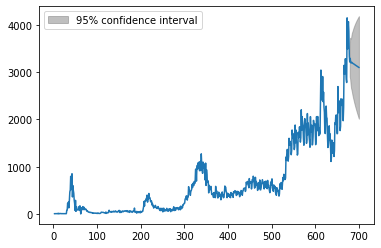

In [13]:
from statsmodels.tsa.ar_model import AutoReg
mod = AutoReg(ko.new_cases,3,old_names=False)
res = mod.fit()
print(res.summary())
fig = res.plot_predict(1,700)

In [24]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(ko.new_cases, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

fig = model_fit.plot_predict(1,700)

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  679
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4422.919
Date:                Sun, 12 Jun 2022   AIC                           8849.837
Time:                        02:40:27   BIC                           8858.876
Sample:                             0   HQIC                          8853.336
                                - 679                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0072      0.025      0.286      0.775      -0.042       0.057
sigma2       2.73e+04    486.188     56.156      0.000    2.63e+04    2.83e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'